This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

In dividing and classifying the city names within the data-set, __[this article from the New York Times](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__ was instrumental as was __[this website](http://zakhor-online.com/?attachment_id=7932)__ and __[this one.](https://www.vox.com/a/maps-explain-the-middle-east)__
__[and this one too](http://gulf2000.columbia.edu/maps.shtml)__ https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8

In this notebook, we will try and isolate data related to cyber-warfare or hacking events.

In [148]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1. Importing, Cleaning and General Overview:

#### A. Importing Data.

In [149]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AN, AP, BG, BM:BN, BQ:BR, CD:CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [150]:
# Renaming for usability:

cyber_data = pd.DataFrame(df.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended':'24+hrs', 'provstate':'region_2', 'doubtterr':'doubt', 
             'attacktype1':'attack_1', 'attacktype1_txt':'attack_1txt','attacktype2':'attack_2', 
             'targtype1':'target_1', 'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
             'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
             'natlty1':'victim_nationality', 'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
             'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 'weaptype1':'weapon', 
             'weaptype1_txt':'weapontxt', 'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

#### B. Selecting Rows Specific to Our Question:


In [151]:
# Creating the dyber_cyber_train_input Dataframe:
# Regex to isolate qualifying data (This set is more flexible in its Regex):
import re
import gc

print(cyber_data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

# Creating a mask which represents the results from our search above:

mask = cyber_data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Creating a new, filtered dataframe with this specific information:

cyber_data = pd.DataFrame(cyber_data[mask])

False    172205
True       9486
Name: summary, dtype: int64


#### C. Splitting Our train/train Data:

In [152]:
from sklearn.model_selection import cross_val_score, train_test_split

In [153]:
# Defining our Input and Output:
# Cleaning later to prevent leakage.

X = cyber_data.drop(['event_id', 'success', 'summary', 'motive'], axis = 1)
Y = pd.DataFrame(cyber_data['success'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25)

X_train_start_index = X_train.index
X_test_start_index = X_test.index
Y_train_start_index = Y_train.index
Y_test_start_index = Y_test.index

#### D. Isolating Columns:

> We want to be sure we are only using the numeric columns that are significant and not arbitrary categoricals:

In [154]:
# Dropping irrelevant columns from training set input and putting it into a datafarme:

cyber_train_input = X_train[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the training output column (i.e. making sure our input and output cyber_train_inputs
# have the same amount of rows):

cyber_train_input_index = cyber_train_input.index

cyber_train_output = Y_train.iloc[Y_train.index == cyber_train_input_index]

In [155]:
# Applying the same process above to our test data:

cyber_test_input = X_test[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the testing output column (i.e. making sure our input and output cyber_test_inputs
# have the same amount of rows):

cyber_test_input_index = cyber_test_input.index

cyber_test_output = Y_test.iloc[Y_test.index == cyber_test_input_index]

#### E. Applying Filters to Text Columns.

> Doing this mainly in the hopes of allowing us to get dummies on certain features which is small enough to use for explanatory purposes (i.e. avoiding a feature set with thousands of columns).

##### Weapontxt:

> ###### Training Input:

In [156]:
# Grouping Biological and Chemical Weapons:
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


> ###### Test Input:

In [157]:
# Grouping Biological and Chemical Weapons:
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


##### Sub_targettxt:

> ###### Training Input:

In [158]:
industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protrainer', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'train/train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

> ###### Test Input:

In [159]:
# Test Input:

industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protester', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'test/test Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

##### Group_name:

> Trying Group_name a bit and grouping them by Ideaology.

> ###### Training Input:

In [160]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [161]:
# Asian Separatists:

cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [162]:
# Middle Eastern Separatists
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [163]:
# Indian Separatists
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [164]:
# African Political:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [165]:
# Irish Separatists
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Irish Republican Army (IRA)',
                                                        'rish_Separatists')


In [166]:
# Farc left and right
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [167]:
# Middle Eastern Religious:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [168]:
# Israeli, Palestinian, Lebanese Religious:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [169]:
# Asian and African Religious:

cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Boko Haram',
                                                        'African_Religious')


> ###### Test Input:

In [170]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [171]:
# Asian Separatists:

cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [172]:
# Middle Eastern Separatists
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [173]:
# Indian Separatists
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [174]:
# African Political:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [233]:
# Irish Separatists
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Irish Republican Army (IRA)',
                                                        'Irish_Separatists')


In [176]:
# Farc left and right
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [177]:
# Middle Eastern Religious:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [178]:
# Israeli, Palestinian, Lebanese Religious:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [179]:
# Asian and African Religious:

cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Boko Haram',
                                                        'African_Religious')


##### City:

> Trying City Names by Religion, Tribal Associations or Conflict Areas:

> ###### Training Input:

In [180]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [181]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [182]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [183]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [184]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [185]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [186]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [187]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [188]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


> ###### Test Input:

In [189]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [190]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [191]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [192]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [193]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [194]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [195]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [196]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [197]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


### 2. Preliminary Visualizations and Exploration:

> Taking a look to see what is happening:

#### A. Correlation:

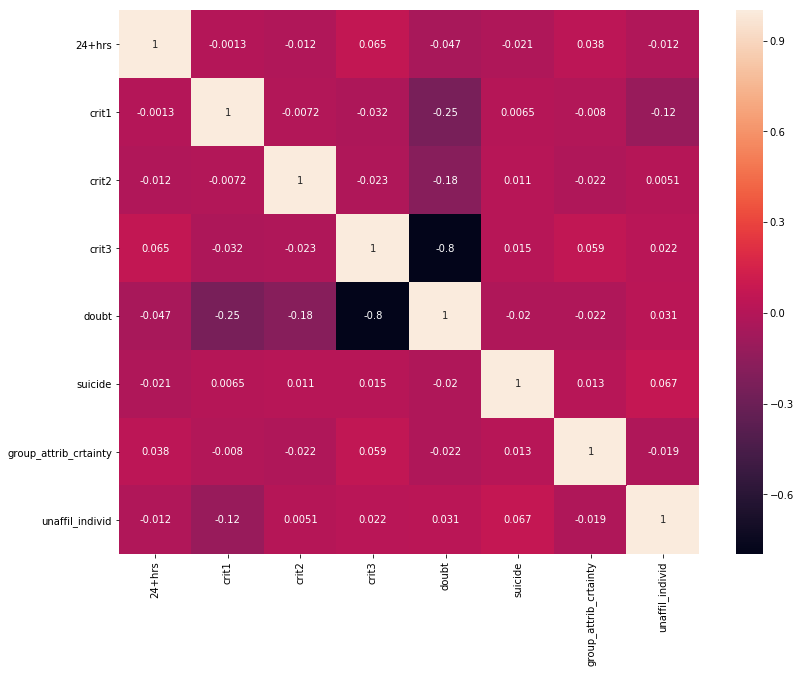

In [110]:
f, ax = plt.subplots(figsize = (13, 10))
sns.heatmap(cyber_train_input.corr(), annot = True)
plt.show()

### 3. Feature Selection:

> Getting closer to modeling and using feature selection algorithms to see what will help us best minimize our feature set while maintaining the most amount of variation in our dataset.

#### A. Select K-Best:

In [198]:
# Scouting out the null situation:

print(cyber_train_input.shape)
cyber_train_input.isna().sum()

(7114, 19)


24+hrs                     0
country_txt                0
region_txt                 0
city                      39
crit1                      0
crit2                      0
crit3                      0
doubt                      0
suicide                    0
attack_1txt                0
target_1txt                0
sub_targettxt            369
specific_target           13
victim_nationalitytxt     79
group_name                 0
group_attrib_crtainty     39
unaffil_individ            0
weapontxt                  0
sub_weapontxt            515
dtype: int64

In [199]:
print(cyber_test_input.shape)
cyber_test_input.isna().sum()

(2372, 19)


24+hrs                     0
country_txt                0
region_txt                 0
city                       7
crit1                      0
crit2                      0
crit3                      0
doubt                      0
suicide                    0
attack_1txt                0
target_1txt                0
sub_targettxt            112
specific_target            1
victim_nationalitytxt     35
group_name                 0
group_attrib_crtainty      8
unaffil_individ            0
weapontxt                  0
sub_weapontxt            156
dtype: int64

> Since the null values are relatively few, we will go ahead and drop them from the input dataframes.  This could be better than imputing the mode

##### Assessing Overall DF:

In [234]:
from sklearn import feature_selection

# Getting dummies or our input train and test data:

cyber_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input.dropna(axis = 0)))
train_dummy_index = cyber_train_dummy.index
cyber_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in train_dummy_index)])

cyber_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input.dropna(axis = 0)))
test_dummy_index = cyber_test_dummy.index
cyber_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in test_dummy_index)])

In [235]:
# Making sure we have the same sizes still:

print(cyber_train_dummy.shape)
print(cyber_train_output2.shape)

print(cyber_test_dummy.shape)
print(cyber_test_output2.shape)

(6168, 7271)
(6168, 1)
(2088, 3002)
(2088, 1)


In [236]:
# Fitting SelectKBest to our Features and output:

KBest_1 = feature_selection.SelectKBest(k = 30)

KBest_1.fit(cyber_train_dummy, cyber_train_output2)
KBest_1_input = KBest_1.fit_transform(cyber_train_dummy, cyber_train_output2)

In [237]:
# Creating a DF with the top 30 features:

feature_mask = KBest_1.get_support(indices = True)
KBest_1_features = pd.DataFrame(cyber_train_dummy.columns[feature_mask])

# # Summarizing the scores for those top 30 features in a df:

KBest_1_features['P_Vals'] = KBest_1.pvalues_[0:30]
KBest_1_features['Scores'] = KBest_1.scores_[0:30]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_1_features

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,24+hrs,3.236747e-11,44.189385
1,country_txt_Ireland,5.075805e-01,0.439103
2,region_txt_Western Europe,7.086516e-01,0.139640
3,city_Baharak district,3.200333e-05,17.320652
4,city_Dublin,5.277050e-05,16.368903
5,city_Imphal,2.585566e-02,4.968049
6,city_Pagadian,3.325494e-01,0.939092
7,attack_1txt_Assassination,1.757641e-01,1.833502
8,attack_1txt_Bombing/Explosion,5.527167e-03,7.703772
9,attack_1txt_Hostage Taking (Kidnapping),1.104469e-01,2.548548


##### Assessing Individual Features:

> Running SelectKBest on a few columns individually to see which of their values is selected as most important:  


> ###### Group_name:

In [238]:
# Getting dummies or our input train and test data:

name_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['group_name'].dropna(axis = 0)))
name_train_dummy_index = name_train_dummy.index
name_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in name_train_dummy_index)])

name_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['group_name'].dropna(axis = 0)))
name_test_dummy_index = cyber_test_dummy.index
name_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in name_test_dummy_index)])

In [239]:
# Group_names:

KBest_names = feature_selection.SelectKBest(k = 30)
KBest_names.fit(name_train_dummy, name_train_output2)
KBest_names_input = KBest_names.fit_transform(name_train_dummy, name_train_output2)

names_mask = KBest_names.get_support(indices = True)
KBest_names_features = pd.DataFrame(name_train_dummy.columns[names_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_names_features['P_Vals'] = KBest_names.pvalues_[0:30]
KBest_names_features['Scores'] = KBest_names.scores_[0:30]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_names_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Anti-Gun Control extremists,0.652192,0.203165
1,Armed Commandos of Liberation,0.749967,0.101567
2,Bangladesh Nationalist Party (BNP),0.749967,0.101567
3,Besi Merah Putih Militia,0.749967,0.101567
4,Communist Party of India - Maoist (CPI-Maoist),0.749967,0.101567
5,Communist Party of Nepal - Maoist (CPN-Maoist-...,0.749967,0.101567
6,Communist Party of Nepal-Maoist (Baidya),0.749967,0.101567
7,Hekla Reception Committee-Initiative for More ...,0.749967,0.101567
8,Hushaysh Tribal Members,0.652192,0.203165
9,Informal Anarchist Federation,0.749967,0.101567


> ###### City:

In [243]:
# Getting dummies or our input train and test data:

city_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['city'].dropna(axis = 0)))
city_train_dummy_index = city_train_dummy.index
city_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in city_train_dummy_index)])

city_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['city'].dropna(axis = 0)))
city_test_dummy_index = cyber_test_dummy.index
city_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in city_test_dummy_index)])

In [244]:
# Group_city:

KBest_city = feature_selection.SelectKBest(k = 30)
KBest_city.fit(city_train_dummy, city_train_output2)
KBest_city_input = KBest_city.fit_transform(city_train_dummy, city_train_output2)

city_mask = KBest_city.get_support(indices = True)
KBest_city_features = pd.DataFrame(city_train_dummy.columns[city_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_city_features['P_Vals'] = KBest_city.pvalues_[0:30]
KBest_city_features['Scores'] = KBest_city.scores_[0:30]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_city_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Aguada,0.749642,0.101840
1,Antrim,0.651755,0.203712
2,Baharak district,0.046572,3.962167
3,Belbari,0.749642,0.101840
4,Belfast,0.749642,0.101840
5,Bosaso,0.001724,9.830298
6,Chukitong,0.749642,0.101840
7,Dublin,0.749642,0.101840
8,Faizabad,0.333141,0.936779
9,Gaya district,0.749642,0.101840


#### B. Principle Component Analysis:

> ##### Assessing Overall DF:

In [252]:
from sklearn.decomposition import PCA

# Using the whole dataset (cyber_train_data):

PCA_1 = decomposition.PCA(n_components = 30)
PCA_1.fit(cyber_train_dummy, cyber_test_output2)
PCA_1_input = PCA_1.fit_transform(cyber_train_dummy, cyber_test_output2)

In [253]:
PCA_1_df = pd.DataFrame(PCA_1.components_, columns = cyber_train_dummy.columns) #always do fit trainsform with pca

> ##### Assessing Individual Features

> ###### Group_name:

In [259]:
# Now looking at group_name stuffs:

PCA_names = PCA(n_components = 30)
PCA_names.fit(name_train_dummy, name_train_output2)
PCA_names_input = PCA_names.fit_transform(name_train_dummy, name_train_output2)

PCA_names_df = pd.DataFrame(PCA_names.components_, columns = name_train_dummy.columns)
PCA_names.explained_variance_

array([0.28910025, 0.09263098, 0.0383579 , 0.02377085, 0.02002799,
       0.01645952, 0.01425746, 0.01327396, 0.01171581, 0.00875744,
       0.00582423, 0.00500135, 0.0047265 , 0.00431015, 0.00383767,
       0.00324724, 0.0026337 , 0.00248721, 0.00233735, 0.00210881,
       0.00205984, 0.00196823, 0.001905  , 0.00179601, 0.00168705,
       0.00168703, 0.00160672, 0.00150835, 0.00140548, 0.00135763])

> ###### City:

In [262]:
# Then some city stuff:

PCA_cities = PCA(n_components = 30)
PCA_cities.fit(city_train_dummy, city_train_output2)
PCA_cities_input = PCA_cities.fit_transform(city_train_dummy, city_train_output2)

PCA_cities_df = pd.DataFrame(PCA_cities.components_, columns = city_train_dummy.columns)